In [1]:
from __future__ import division, print_function
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "5"

%cd HepG2

/users/avanti/interpret-benchmark/data/HepG2


In [2]:
%matplotlib inline

import keras
from keras.models import model_from_json
from keras.models import Model
import h5py
import numpy as np
from deeplift import dinuc_shuffle
from matplotlib import pyplot as plt
import sys
from deeplift.visualization import viz_sequence


argmax_to_letter = {0:'A', 1:'C', 2:'G', 3:'T'}
def onehot_to_seq(onehot):
    seq = "".join([argmax_to_letter[x] for x in np.argmax(onehot,axis=-1)])
    return seq

def one_hot_encode_along_channel_axis(sequence):
    to_return = np.zeros((len(sequence),4), dtype=np.int8)
    seq_to_one_hot_fill_in_array(zeros_array=to_return,
                                 sequence=sequence, one_hot_axis=1)
    return to_return

def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1): 
        assert zeros_array.shape[0] == len(sequence)
    #will mutate zeros_array
    for (i,char) in enumerate(sequence):
        if (char=="A" or char=="a"):
            char_idx = 0
        elif (char=="C" or char=="c"):
            char_idx = 1
        elif (char=="G" or char=="g"):
            char_idx = 2
        elif (char=="T" or char=="t"):
            char_idx = 3
        elif (char=="N" or char=="n"):
            continue #leave that pos as all 0's
        else:
            raise RuntimeError("Unsupported character: "+str(char))
        if (one_hot_axis==0):
            zeros_array[char_idx,i] = 1
        elif (one_hot_axis==1):
            zeros_array[i,char_idx] = 1


Using TensorFlow backend.


In [54]:

#dan preinit
model_prefix = "record_21_model_NZqHC"
#model_prefix = "record_20_model_QFbAM"

#trained from scratch
#model_prefix = "record_15_model_REDP7"

model_weights = "model_files/"+model_prefix+"_modelWeights.h5"
model_json = "model_files/"+model_prefix+"_modelJson.json"

keras_model = model_from_json(open(model_json).read())
keras_model.load_weights(model_weights)

preact_model = Model(inputs=keras_model.input,
                     outputs=keras_model.layers[-2].output)

imp_scores_fh = h5py.File("imp_scores_"+model_prefix+".h5", "r")
onehot_seq = np.array(imp_scores_fh['onehot'])
orig_preds = preact_model.predict(onehot_seq).squeeze()

seqs = [onehot_to_seq(x) for x in onehot_seq]
shuffled_onehot_seqs = []
num_shuffles_to_make = 10
for i in range(num_shuffles_to_make):
    shuffled_onehot_seqs.append(np.array(
            [one_hot_encode_along_channel_axis(dinuc_shuffle.dinuc_shuffle(x)) for x in seqs]))

In [55]:
method_to_zerod_diffs = {}
method_to_subbed_diffs = {}

percentile = 90

scoring_methods = [
    'scores_ism',
    'scores_deeplift_rescale_dinucshuff',
    'scores_deeplift_genomicsdefault_dinucshuff',
    'scores_integrated_grad20_dinucshuff',
    'scores_grad_times_inp_flatref',
    
    'scores_integrated_grad20_avgposref',
    'scores_deeplift_rescale_avgposref',
    'scores_deeplift_genomicsdefault_avgposref',
    'scores_integrated_grad20_flatref',
    'scores_deeplift_rescale_flatref',
    'scores_deeplift_genomicsdefault_flatref',
    
    'scores_integrated_grad10_dinucshuff',
    'scores_integrated_grad2_dinucshuff',
    'scores_integrated_grad5_dinucshuff',     
]

for method in scoring_methods:
    #print(method)
    sys.stdout.flush()
    scores = np.array(imp_scores_fh[method])
    central_scores = scores[:,350:650]
    
    #for each example, zero out the top 10% of scores
    
    to_zero = list(zip(*np.nonzero(central_scores > np.percentile(central_scores,percentile))))
    #print(len(to_zero))
    
    #to_zero = [
    #    (i,x) for i,ex_central_scores in enumerate(central_scores)
    #     for x in np.nonzero(ex_central_scores >
    #                         np.percentile(ex_central_scores,percentile))[0]
    #]
    #print(len(to_zero))
    
    zerod_inputs = np.array(onehot_seq)
    for example_idx, col_idx in to_zero:
        zerod_inputs[example_idx,350+col_idx] = 0
        
    subbed_inputs_sets = []
    for i in range(num_shuffles_to_make):
        subbed_inputs = np.array(onehot_seq)
        for example_idx, col_idx in to_zero:
            subbed_inputs[example_idx,350+col_idx] = shuffled_onehot_seqs[i][example_idx,350+col_idx]
        subbed_inputs_sets.append(subbed_inputs)
    mean_subbed_preds = np.mean(np.array([preact_model.predict(x).squeeze() for x in subbed_inputs_sets]),axis=0)
    method_to_subbed_diffs[method] = orig_preds-mean_subbed_preds
    print("avg_diff_meansubbed",method,np.mean(orig_preds-mean_subbed_preds))
    
    #viz_sequence.plot_weights((onehot_seq[0]*scores[0][:,None])[350:650])
    #viz_sequence.plot_weights((altered_inputs[0]*scores[0][:,None])[350:650])
    
    zerod_preds = np.squeeze(preact_model.predict(zerod_inputs))
    method_to_zerod_diffs[method] = orig_preds-zerod_preds
    #print("total_diff_zerod",method,np.sum(orig_preds-zerod_preds))
    
    sys.stdout.flush()
#    plt.hist(central_scores.ravel(),bins=50)
#    plt.show()

avg_diff_meansubbed scores_ism 25.42139
avg_diff_meansubbed scores_deeplift_rescale_dinucshuff 25.561928
avg_diff_meansubbed scores_deeplift_genomicsdefault_dinucshuff 24.869923
avg_diff_meansubbed scores_integrated_grad20_dinucshuff 18.51897
avg_diff_meansubbed scores_grad_times_inp_flatref 21.297049
avg_diff_meansubbed scores_integrated_grad20_avgposref 16.58982
avg_diff_meansubbed scores_deeplift_rescale_avgposref 10.904641
avg_diff_meansubbed scores_deeplift_genomicsdefault_avgposref 10.775901
avg_diff_meansubbed scores_integrated_grad20_flatref 13.873214
avg_diff_meansubbed scores_deeplift_rescale_flatref 17.804165
avg_diff_meansubbed scores_deeplift_genomicsdefault_flatref 14.288139
avg_diff_meansubbed scores_integrated_grad10_dinucshuff 18.326775
avg_diff_meansubbed scores_integrated_grad2_dinucshuff 15.15495
avg_diff_meansubbed scores_integrated_grad5_dinucshuff 15.15495


Compare to ISM


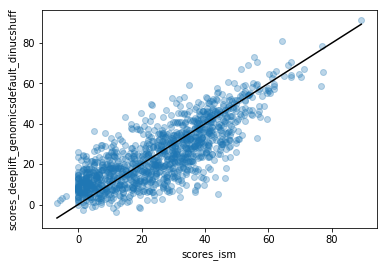

pos ranks sum 366947 neg ranks sum 402473
WilcoxonResult(statistic=366947.0, pvalue=0.1590262830664374)


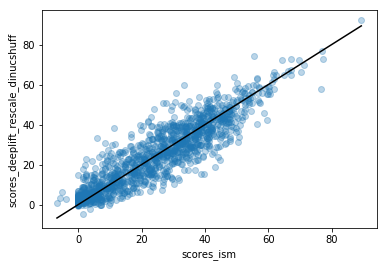

pos ranks sum 389084 neg ranks sum 380326
WilcoxonResult(statistic=377842.0, pvalue=0.7264627376984332)


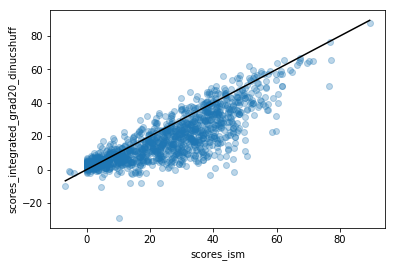

pos ranks sum 110553 neg ranks sum 658867
WilcoxonResult(statistic=110553.0, pvalue=9.217724560514878e-105)


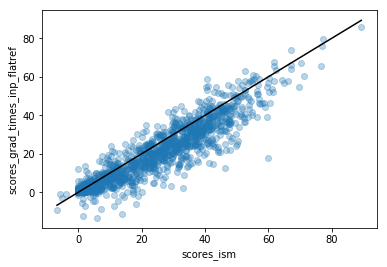

pos ranks sum 144662 neg ranks sum 624653
WilcoxonResult(statistic=139916.0, pvalue=7.14569622890283e-81)
Dinuc shuff ref is better


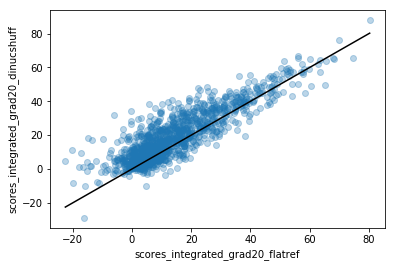

pos ranks sum 628027 neg ranks sum 141393
WilcoxonResult(statistic=141393.0, pvalue=6.320296732928066e-83)


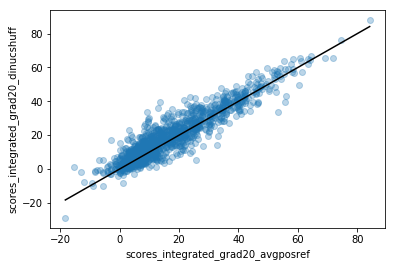

pos ranks sum 535025 neg ranks sum 234395
WilcoxonResult(statistic=234395.0, pvalue=9.554512598946638e-33)
Intgrad vs deeplift


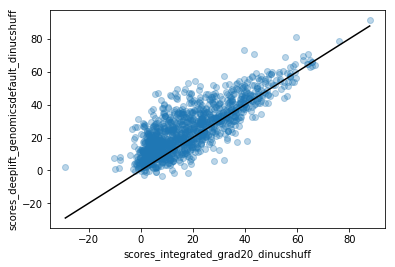

pos ranks sum 647617 neg ranks sum 121803
WilcoxonResult(statistic=121803.0, pvalue=1.6993044555311606e-96)


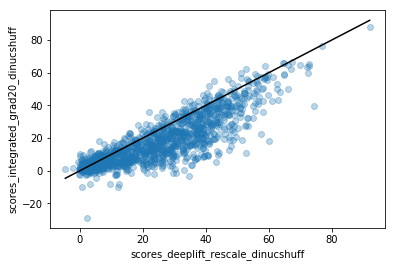

pos ranks sum 86807 neg ranks sum 682613
WilcoxonResult(statistic=86807.0, pvalue=2.4310823920279745e-123)
Deeplift revealcancel vs rescale


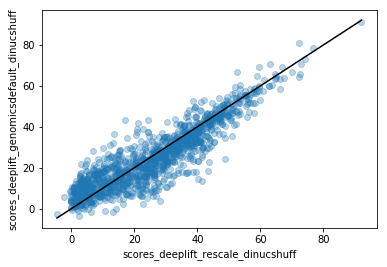

pos ranks sum 341855 neg ranks sum 427559
WilcoxonResult(statistic=340208.0, pvalue=0.0006904920339489118)
Grad times inp vs intgrad


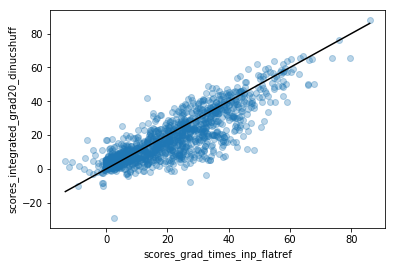

pos ranks sum 265467 neg ranks sum 503953
WilcoxonResult(statistic=265467.0, pvalue=3.2525677273018467e-21)
Intgrad 2 vs 20


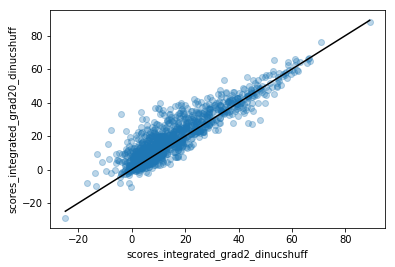

pos ranks sum 589194 neg ranks sum 180226
WilcoxonResult(statistic=180226.0, pvalue=4.102735954213044e-59)
Intgrad 5 vs 20


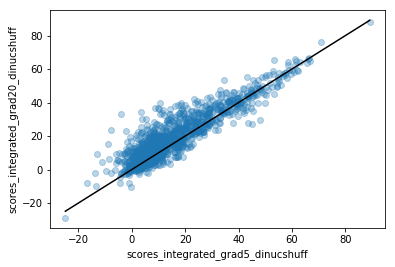

pos ranks sum 589194 neg ranks sum 180226
WilcoxonResult(statistic=180226.0, pvalue=4.102735954213044e-59)


In [56]:
import scipy
from scipy import stats

def compare_methods(method_1_name, method_2_name, score_lookup):
    method_1_scores=score_lookup[method_1_name]
    method_2_scores=score_lookup[method_2_name]
    plt.scatter(method_1_scores, method_2_scores, alpha=0.3)
    plt.plot([np.min(method_1_scores), np.max(method_1_scores)],
             [np.min(method_1_scores), np.max(method_1_scores)],
             color="black")
    plt.xlabel(method_1_name)
    plt.ylabel(method_2_name)
    plt.show()
    differences = method_2_scores-method_1_scores
    sorted_differences = sorted(differences,key=lambda x:np.abs(x))
    #print(sorted_differences)
    positive_ranks = sum([x[0]+1 for x in enumerate(sorted_differences) if x[1] > 0])
    negative_ranks = sum([x[0]+1 for x in enumerate(sorted_differences) if x[1] < 0])
    print("pos ranks sum",positive_ranks, "neg ranks sum", negative_ranks)
    print(scipy.stats.wilcoxon(differences))
    
diffs_lookup = method_to_subbed_diffs    

print("Compare to ISM")

compare_methods(method_1_name="scores_ism",
                method_2_name="scores_deeplift_genomicsdefault_dinucshuff",
                score_lookup=diffs_lookup)
compare_methods(method_1_name="scores_ism",
                method_2_name="scores_deeplift_rescale_dinucshuff",
                score_lookup=diffs_lookup)
compare_methods(method_1_name="scores_ism",
                method_2_name="scores_integrated_grad20_dinucshuff",
                score_lookup=diffs_lookup)
compare_methods(method_1_name="scores_ism",
                method_2_name="scores_grad_times_inp_flatref",
                score_lookup=diffs_lookup)

print("Dinuc shuff ref is better")
compare_methods(method_1_name="scores_integrated_grad20_flatref",
                method_2_name="scores_integrated_grad20_dinucshuff",
                score_lookup=diffs_lookup)
compare_methods(method_1_name="scores_integrated_grad20_avgposref",
                method_2_name="scores_integrated_grad20_dinucshuff",
                score_lookup=diffs_lookup)

print("Intgrad vs deeplift")

compare_methods(method_1_name="scores_integrated_grad20_dinucshuff",
                method_2_name="scores_deeplift_genomicsdefault_dinucshuff",
                score_lookup=diffs_lookup)

compare_methods(method_1_name="scores_deeplift_rescale_dinucshuff",
                method_2_name="scores_integrated_grad20_dinucshuff",
                score_lookup=diffs_lookup)

print("Deeplift revealcancel vs rescale")

compare_methods(method_1_name="scores_deeplift_rescale_dinucshuff",
                method_2_name="scores_deeplift_genomicsdefault_dinucshuff",
                score_lookup=diffs_lookup)


print("Grad times inp vs intgrad")
compare_methods(method_1_name="scores_grad_times_inp_flatref",
                method_2_name="scores_integrated_grad20_dinucshuff",
                score_lookup=diffs_lookup)

print("Intgrad 2 vs 20")
compare_methods(method_1_name="scores_integrated_grad2_dinucshuff",
                method_2_name="scores_integrated_grad20_dinucshuff",
                score_lookup=diffs_lookup)

print("Intgrad 5 vs 20")
compare_methods(method_1_name="scores_integrated_grad5_dinucshuff",
                method_2_name="scores_integrated_grad20_dinucshuff",
                score_lookup=diffs_lookup)


In [57]:
def vis_examples_favoring_method_1(method_1_name, method_2_name,
                                   perf_lookup, imp_scores_fh,
                                   onehot_seq,
                                   num_to_plot=3):
    method_1_perfs = perf_lookup[method_1_name]
    method_2_perfs = perf_lookup[method_2_name]
    method_1_minus_method_2_perfs = method_1_perfs - method_2_perfs
    top_method_1_examples = [x[0] for x in sorted(enumerate(method_1_minus_method_2_perfs),
                                   key=lambda x: -x[1]) if x[1] > 0]
    
    method_1_scores = np.array(imp_scores_fh[method_1_name])
    method_2_scores = np.array(imp_scores_fh[method_2_name])
    
    print(len(top_method_1_examples))
    for ex_id in top_method_1_examples[::int(len(top_method_1_examples)/num_to_plot)]:
        print("Example_idx",ex_id,"pred",orig_preds[ex_id],
              method_1_name+"_diff",method_1_perfs[ex_id],
              method_2_name+"_diff",method_2_perfs[ex_id])
        print(method_1_name+" imp scores")
        viz_sequence.plot_weights((onehot_seq[ex_id]*method_1_scores[ex_id][:,None])[350:650],
                                  subticks_frequency=20)
        print(method_2_name+" imp scores")
        viz_sequence.plot_weights((onehot_seq[ex_id]*method_2_scores[ex_id][:,None])[350:650],
                                  subticks_frequency=20)

549
Example_idx 59 pred 43.558468 scores_deeplift_genomicsdefault_dinucshuff_diff 43.156372 scores_deeplift_rescale_dinucshuff_diff 16.901482
scores_deeplift_genomicsdefault_dinucshuff imp scores


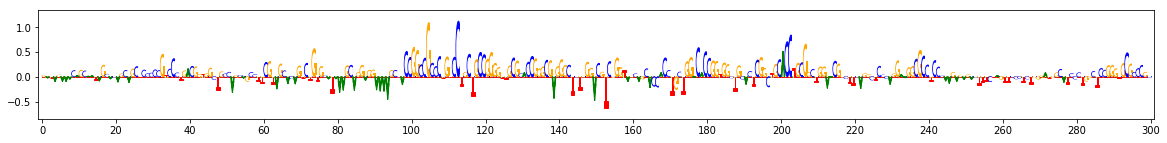

scores_deeplift_rescale_dinucshuff imp scores


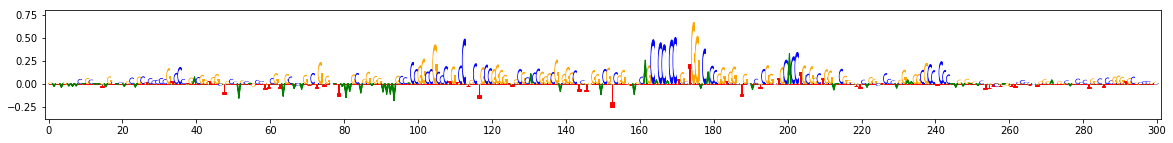

Example_idx 661 pred 18.99726 scores_deeplift_genomicsdefault_dinucshuff_diff 14.935646 scores_deeplift_rescale_dinucshuff_diff 7.8917427
scores_deeplift_genomicsdefault_dinucshuff imp scores


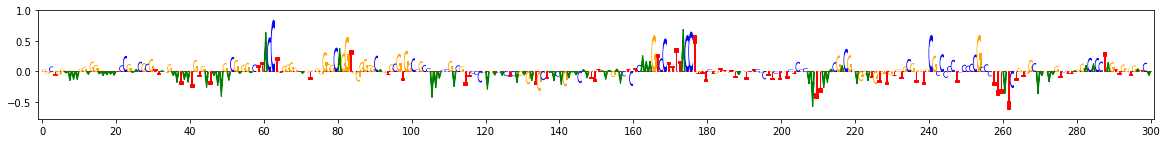

scores_deeplift_rescale_dinucshuff imp scores


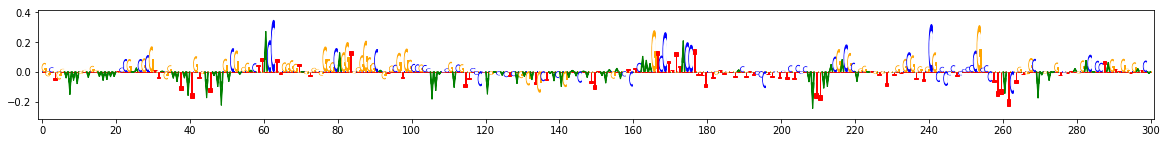

Example_idx 922 pred 6.940238 scores_deeplift_genomicsdefault_dinucshuff_diff 42.23257 scores_deeplift_rescale_dinucshuff_diff 39.66625
scores_deeplift_genomicsdefault_dinucshuff imp scores


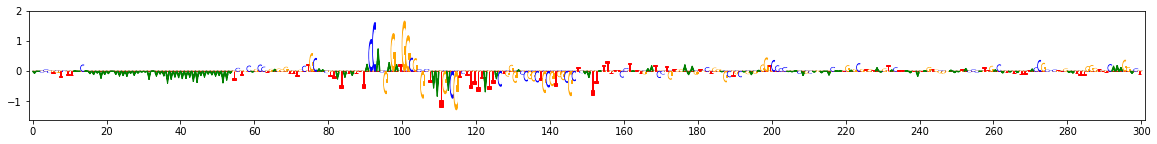

scores_deeplift_rescale_dinucshuff imp scores


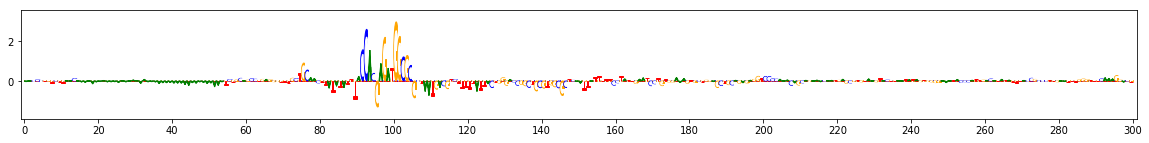

In [58]:
vis_examples_favoring_method_1(method_1_name="scores_deeplift_genomicsdefault_dinucshuff",
                               method_2_name="scores_deeplift_rescale_dinucshuff",
                               perf_lookup=method_to_subbed_diffs,
                               imp_scores_fh=imp_scores_fh,
                               onehot_seq=onehot_seq)

616
Example_idx 192 pred 36.342735 scores_deeplift_genomicsdefault_dinucshuff_diff 36.343857 scores_ism_diff 5.0032463
scores_deeplift_genomicsdefault_dinucshuff imp scores


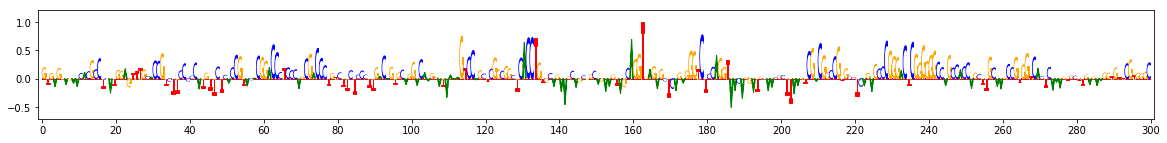

scores_ism imp scores


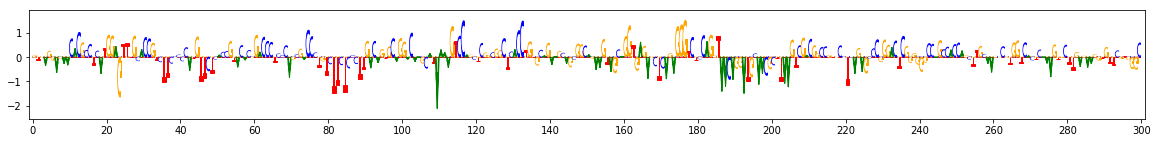

Example_idx 163 pred 37.5243 scores_deeplift_genomicsdefault_dinucshuff_diff 10.806349 scores_ism_diff 1.7150803
scores_deeplift_genomicsdefault_dinucshuff imp scores


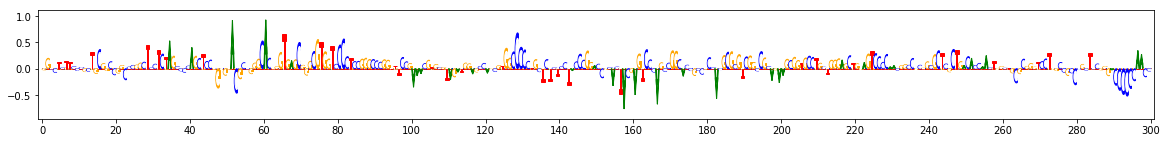

scores_ism imp scores


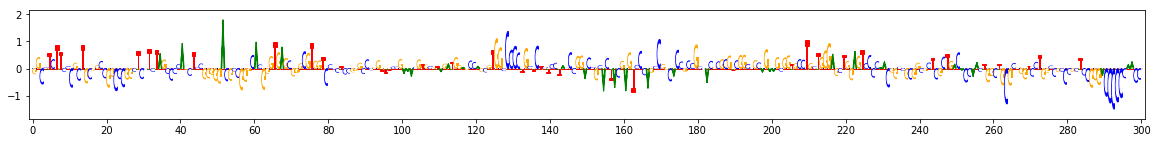

Example_idx 522 pred 24.514029 scores_deeplift_genomicsdefault_dinucshuff_diff 8.269402 scores_ism_diff 4.1776924
scores_deeplift_genomicsdefault_dinucshuff imp scores


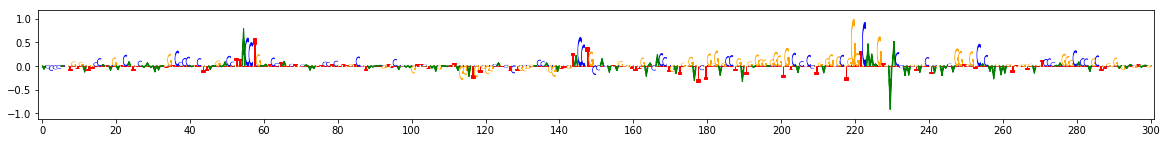

scores_ism imp scores


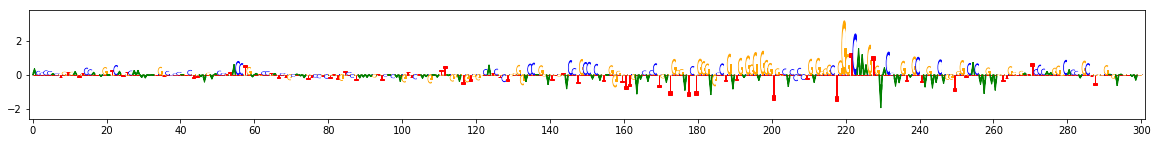

Example_idx 304 pred 32.240067 scores_deeplift_genomicsdefault_dinucshuff_diff 40.912098 scores_ism_diff 40.899513
scores_deeplift_genomicsdefault_dinucshuff imp scores


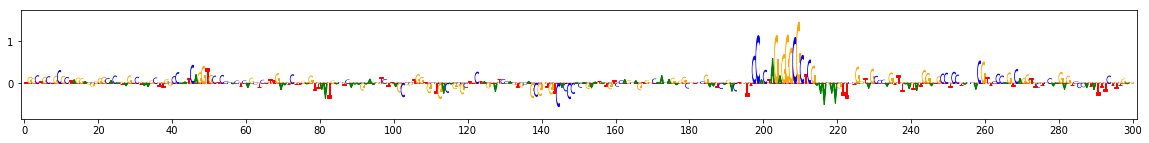

scores_ism imp scores


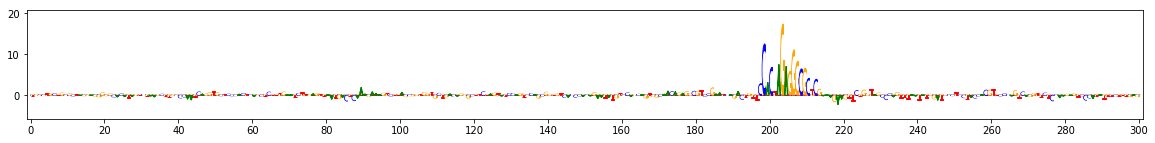

In [59]:
#visualize some examples where one method picks up stuff the other doesn't

vis_examples_favoring_method_1(method_1_name="scores_deeplift_genomicsdefault_dinucshuff",
                               method_2_name="scores_ism",
                               perf_lookup=method_to_subbed_diffs,
                               imp_scores_fh=imp_scores_fh,
                               onehot_seq=onehot_seq)